In [1]:
# Imports
import psycopg2 as pg
import pickle
import pandas.io.sql as psql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scikitplot as skplt

from IPython.core.display import HTML
from IPython.core.display import Image

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Query data and save pickle

In [3]:
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
username = 'member'
port = 5432
database = 'comunidadedsdb'
pwd = 'cdspa'

In [4]:
conn = pg.connect( user = username,
                   password = pwd,
                   host = host,
                   port = port,
                   database = database)

In [5]:
query_tables_users = """
                SELECT *
                FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                                    LEFT JOIN pa004.insurance i ON (u.id = i.id)                                 
                """

# df = psql.read_sql(query_tables_users, conn)
# df.head(22)


In [6]:
# df.shape

In [7]:
# df.to_pickle('df.pkl')

df = pd.read_pickle('df.pkl')

# Data Cleaning

In [8]:
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


## Checking NAs and dtypes

In [9]:
df.gender = df.gender.astype(str)


In [10]:
df.region_code.unique()
df.region_code = df.region_code.astype('int')
df.policy_sales_channel.unique()
df.policy_sales_channel = df.policy_sales_channel.astype('int')
# df.vehicle_age.unique() # < >  <>
# df.vehicle_damage.unique() # yes / no
# df.previously_insured.unique()  # bool 0/1
# df.vintage.unique()
# df.response.unique()  # 0/1

In [11]:
df.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'id',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [12]:
# drop repeated columns
df.columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'ida',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'ida',
       'previously_insured', 'annual_premium', 'vintage', 'response']
df = df.drop(df.columns[[5,9]], axis = 1)

In [13]:
df.info()  # Non-null number all the same, non missing data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  int32  
 4   policy_sales_channel  381109 non-null  int32  
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(3)
memory usage: 32.0+ MB


In [14]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,1-2 Year,Yes,0,42297.0,264,0


# EDA

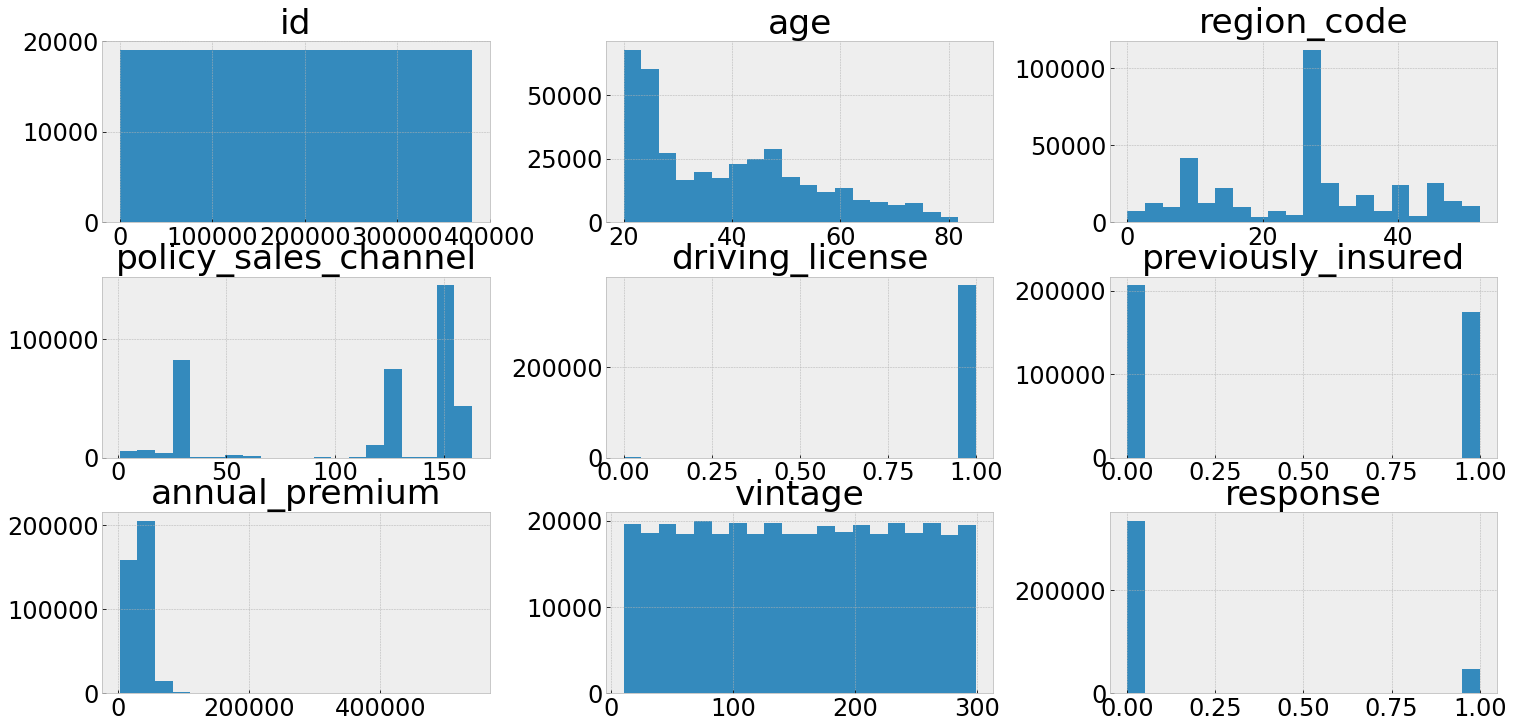

In [15]:
df.hist(bins = 20);

<AxesSubplot:xlabel='annual_premium'>

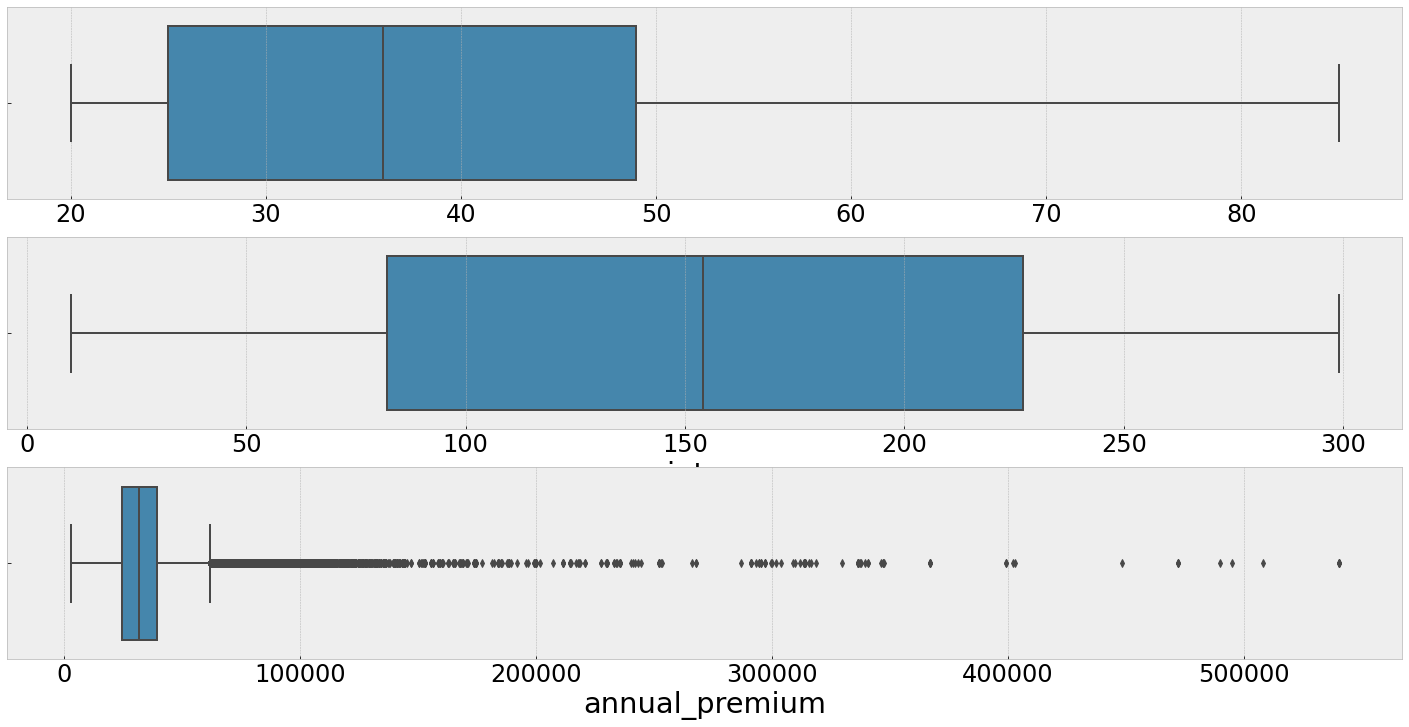

In [16]:
plt.subplot(3,1,1)
sns.boxplot(x = 'age', data = df)
plt.subplot(3,1,2)
sns.boxplot(x = 'vintage', data = df)
plt.subplot(3,1,3)
sns.boxplot(x = 'annual_premium', data = df)

Some premiums are very high

In [17]:
df.annual_premium.quantile(.75)

39400.0

## Comparing Dataset according to survey

### Total Proportion of positive responses

In [18]:
print('Total Observations: ' + str(df.shape[0]))
tot_resp = df.shape[0]
pos_resp = df[df['response'] == 1].shape[0]
neg_resp = df[df['response'] == 0].shape[0]

print(f'Total Positive Responses: {str(pos_resp )}     {str(pos_resp / tot_resp)}')
print(f'Total Negative Responses: {str(neg_resp )}    {str(neg_resp / tot_resp)}')

Total Observations: 381109
Total Positive Responses: 46710     0.12256336113815208
Total Negative Responses: 334399    0.877436638861848


### Gender

<AxesSubplot:xlabel='gender', ylabel='count'>

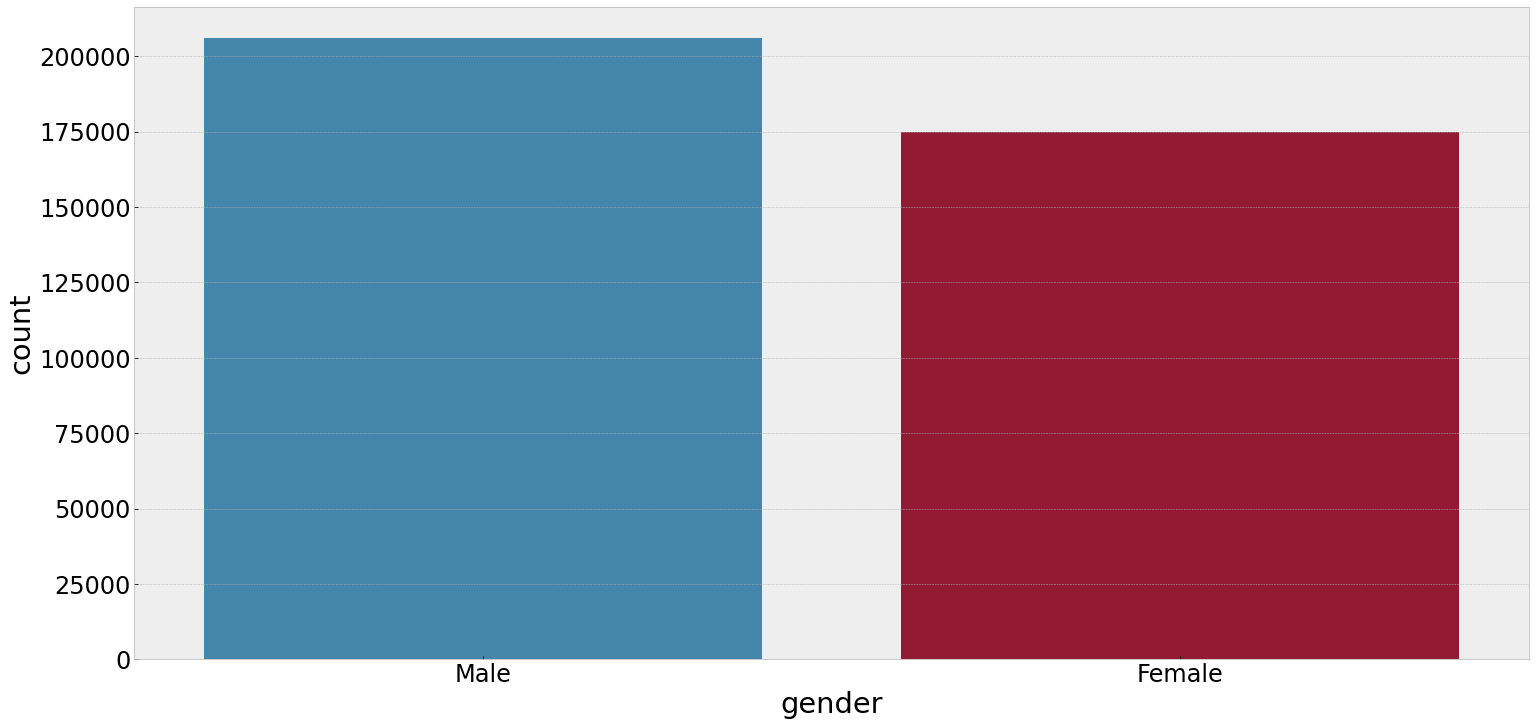

In [19]:
sns.countplot(data = df, x = 'gender')

<AxesSubplot:xlabel='response', ylabel='count'>

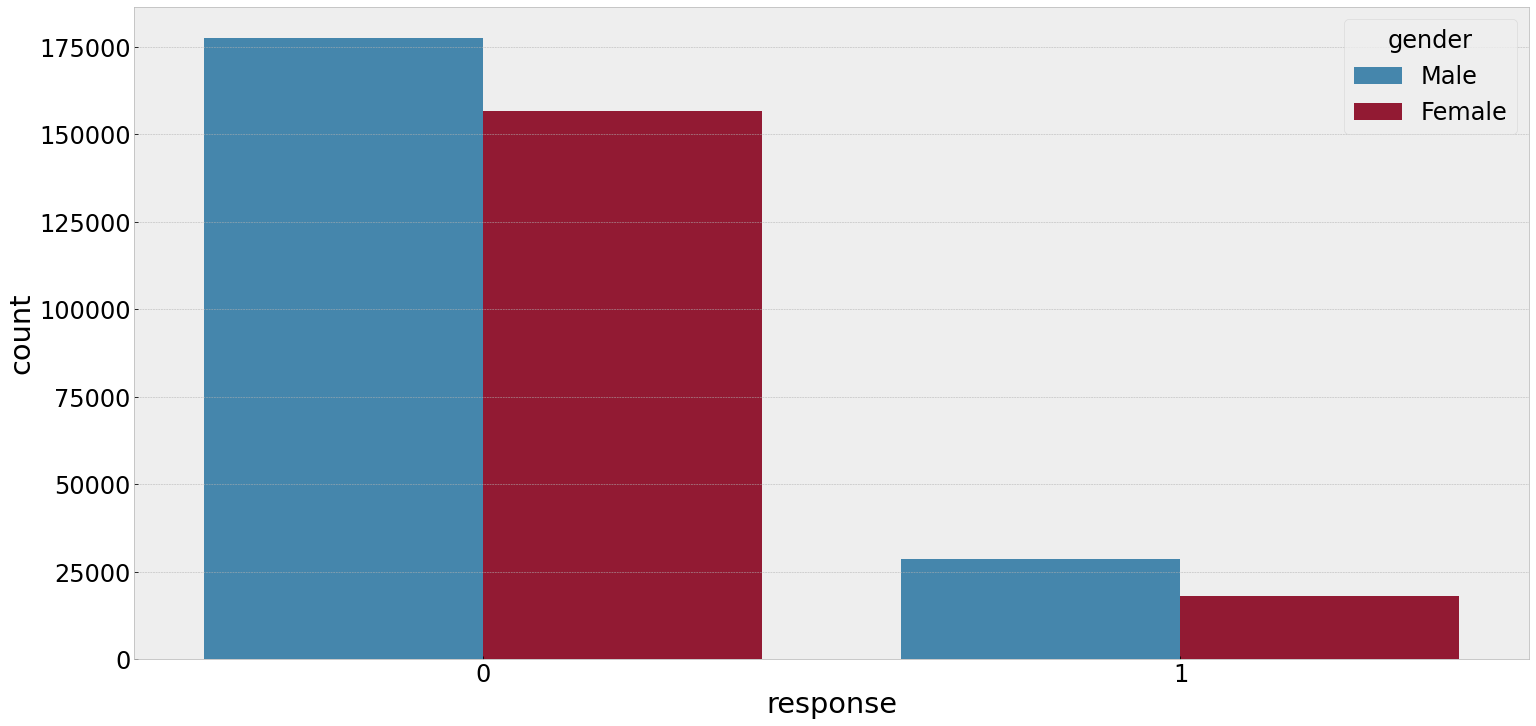

In [20]:
sns.countplot(data = df, x = 'response', hue = 'gender')

Text(0.5, 0.01, 'On the first graph it is possible to check data is biased towards men, since more men has answered the survey. On \nsecond and third graphs we checked the proportion for positive answers within each gender. Men \nanswered 13.84% positively, while Women 10.39%.')

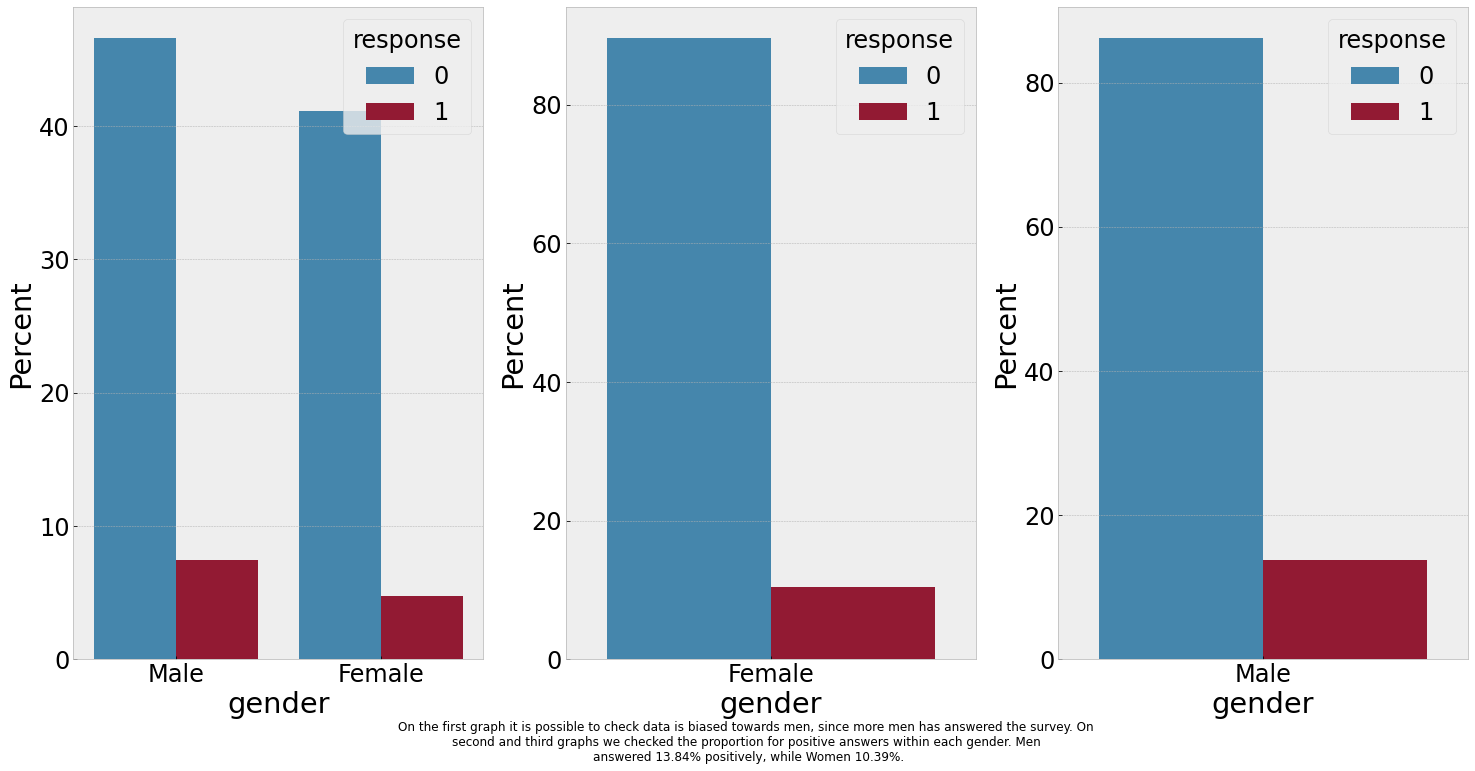

In [21]:
plt.subplot(1,3,1)
ax1 = sns.barplot(x="gender", y="response", hue = 'response', data=df, estimator=lambda x: len(x) / len(df) * 100)
ax1.set(ylabel="Percent")

plt.subplot(1,3,2)
df_aux_female = df[df['gender'] == 'Female']
ax2 = sns.barplot(x="gender", y = 'response', hue = 'response', data=df_aux_female, estimator=lambda x: len(x) / len(df_aux_female) * 100)
ax2.set(ylabel="Percent")
fem_data = len(df_aux_female[df_aux_female['response'] == 1]) / len(df_aux_female) * 100

plt.subplot(1,3,3)
df_aux_male = df[df['gender'] == 'Male']
ax3 = sns.barplot(x="gender", y='response', hue='response', data=df_aux_male, estimator=lambda x: len(x) / len(df_aux_male) * 100)
ax3.set(ylabel="Percent")
male_data = len(df_aux_male[df_aux_male['response'] == 1]) / len(df_aux_male) * 100
txt=f"On the first graph it is possible to check data is biased towards men, since more men has answered the survey. On \nsecond and third graphs we checked the proportion for positive answers within each gender. Men \nanswered {male_data:.2f}% positively, while Women {fem_data:.2f}%."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)



### Age as a factor for Responses

<AxesSubplot:xlabel='age', ylabel='Count'>

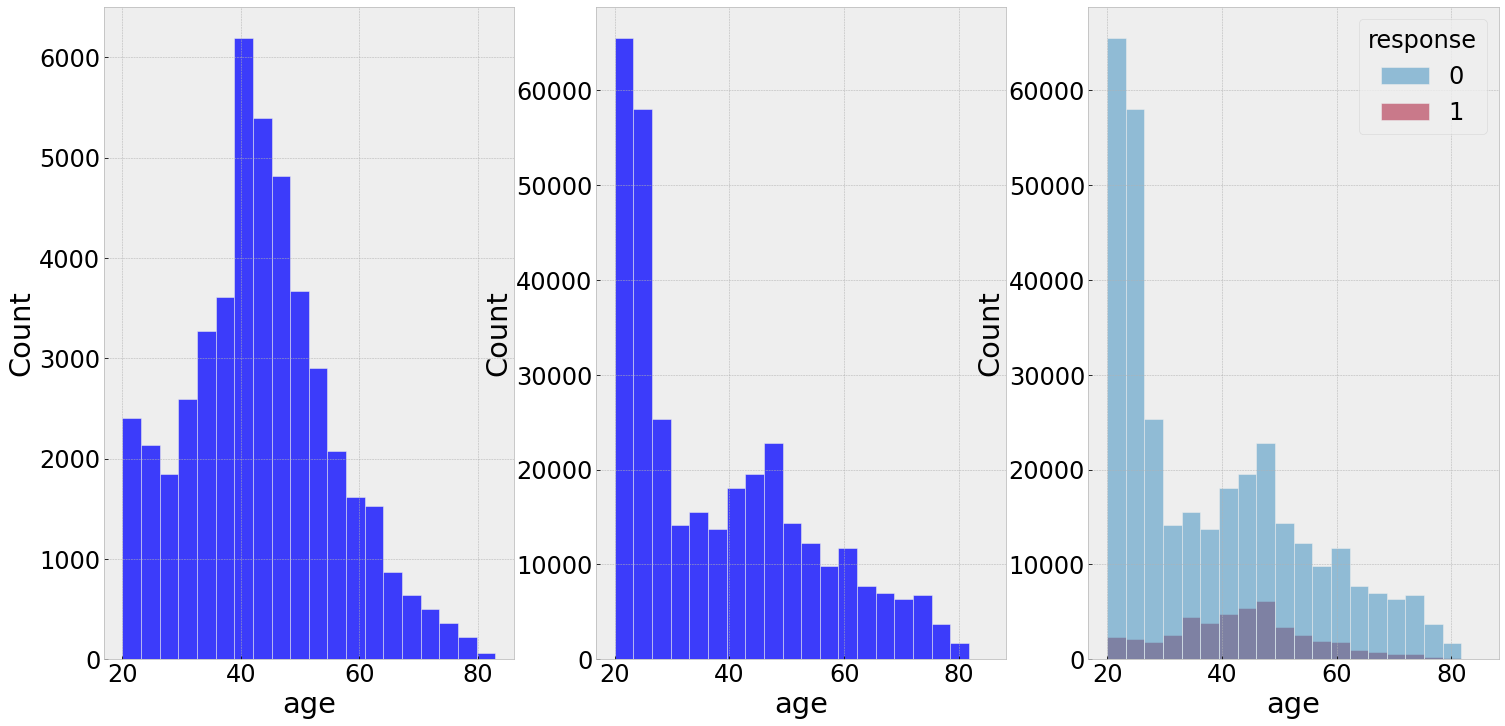

In [22]:
df_positive_feedback = df[df['response'] == 1];

df_negative_feedback = df[df['response'] == 0];

fig, axes = plt.subplots(1,3)
sns.histplot(x = 'age', data = df_positive_feedback, ax = axes[0], bins = 20)
sns.histplot(x = 'age', data = df_negative_feedback, ax = axes[1], bins = 20)
sns.histplot(x = 'age', data = df, hue = 'response', ax = axes[2], bins = 20)


In [23]:
bins = list(range(20,90,5))
df['binned_age'] = pd.cut(df['age'], bins=bins)
age_proportional_aux1 = df[['binned_age','response']].groupby('binned_age').count().reset_index()  # total
age_proportional_aux2 = df[df['response'] == 0][['binned_age','response']].groupby('binned_age').count().reset_index()  # neg
age_proportional_aux3 = df[df['response'] == 1][['binned_age','response']].groupby('binned_age').count().reset_index()  # pos
age_proportional = pd.concat([age_proportional_aux1,age_proportional_aux2,age_proportional_aux3], axis = 1)
age_proportional.columns = ['binned_age','total','b1','negative','b2','positive']
age_proportional = age_proportional.drop(age_proportional.columns[[2,4]], axis = 1)
age_proportional['pos_tot'] = age_proportional.positive / age_proportional.total
age_proportional


,binned_age,total,negative,positive,pos_tot
0,"(20, 25]",108273,104397,3876,0.035798
1,"(25, 30]",46956,43820,3136,0.066786
2,"(30, 35]",25351,20289,5062,0.199677
3,"(35, 40]",29812,23277,6535,0.219207
4,"(40, 45]",40720,32063,8657,0.212598
5,"(45, 50]",35221,27853,7368,0.209193
6,"(50, 55]",26328,21573,4755,0.180606
7,"(55, 60]",18977,16016,2961,0.156031
8,"(60, 65]",15170,13316,1854,0.122215
9,"(65, 70]",12668,11479,1189,0.093859


It seems that age is the major differenct for giving positive feedback regarding doing car insurance, followed by annual_premium.

### Region Code

In [24]:
df.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'binned_age'],
      dtype='object')

In [25]:
region = df[['response','region_code','id']].groupby(['region_code','response']).count().reset_index()

In [26]:
region['pos_response'] = region.apply(lambda x: x['id'] if x['response'] == 1 else 0, axis = 1)

In [27]:
region['neg_response'] = region.apply(lambda x: x['id'] if x['response'] == 0 else 0, axis = 1)

In [28]:
type(region)

region = region[['region_code','pos_response','neg_response']].groupby('region_code').sum().reset_index()

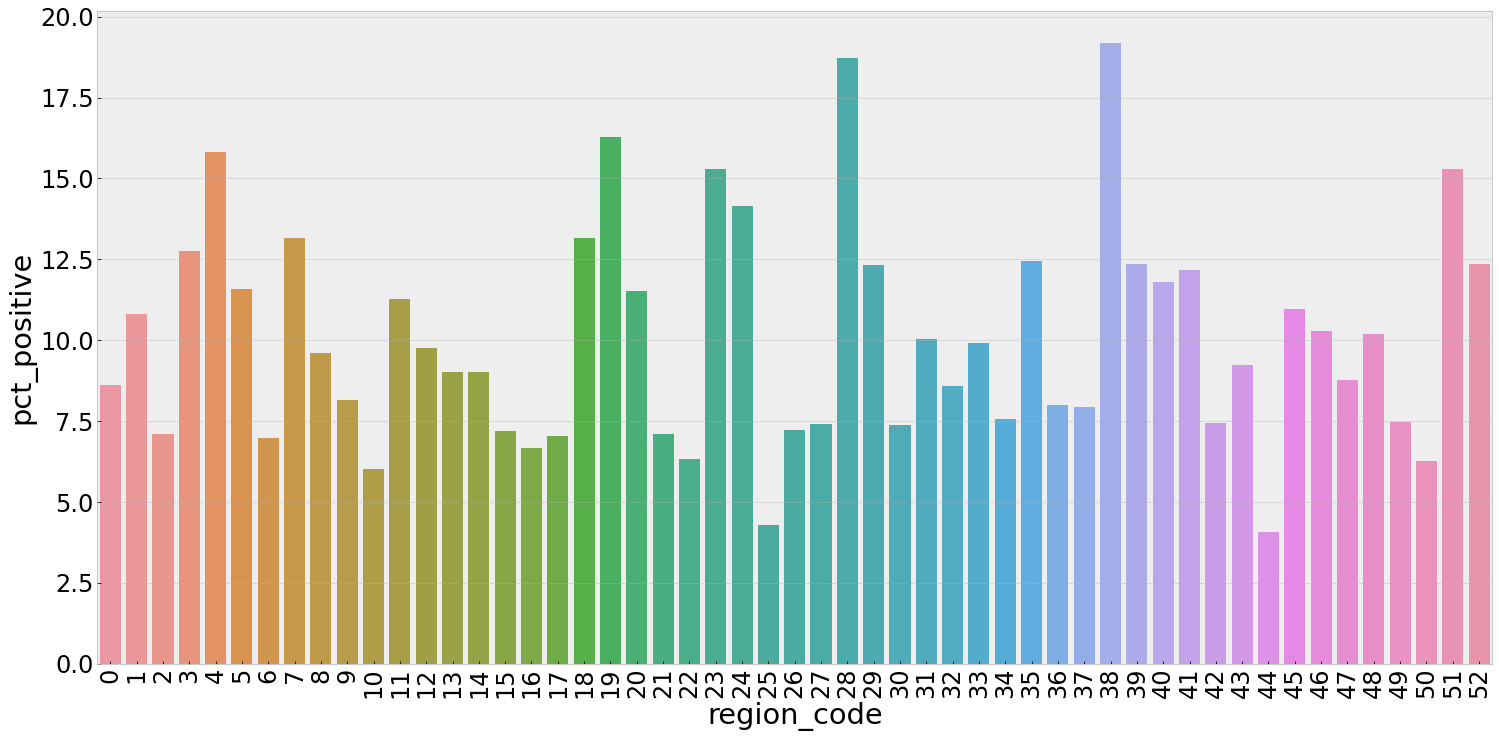

In [29]:
region['tot_answers'] = region['pos_response'] + region['neg_response']

region['pct_positive'] = region['pos_response'] / region['tot_answers'] * 100
region.head(24)
sns.barplot(x = 'region_code', y = 'pct_positive', data = region)
plt.xticks(rotation = 90);

In [30]:
df.dtypes

id                         int64
gender                    object
age                        int64
region_code                int32
policy_sales_channel       int32
driving_license            int64
vehicle_age               object
vehicle_damage            object
previously_insured         int64
annual_premium           float64
vintage                    int64
response                   int64
binned_age              category
dtype: object

### Policy sales Channel

In [31]:
# sns.barplot(y = 'policy_sales_channel', hue = 'response', data = df)

sales_channel = df[['policy_sales_channel', 'response','id']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sales_channel['positive'] = sales_channel.apply(lambda x: x['id'] if x['response'] == 1 else 0, axis = 1)
sales_channel['negative'] = sales_channel.apply(lambda x: x['id'] if x['response'] == 0 else 0, axis = 1)

sales_channel = sales_channel.groupby('policy_sales_channel').sum().reset_index()
sales_channel['tot'] = sales_channel.positive + sales_channel.negative
sales_channel['pct_positive'] = sales_channel.positive / sales_channel.tot

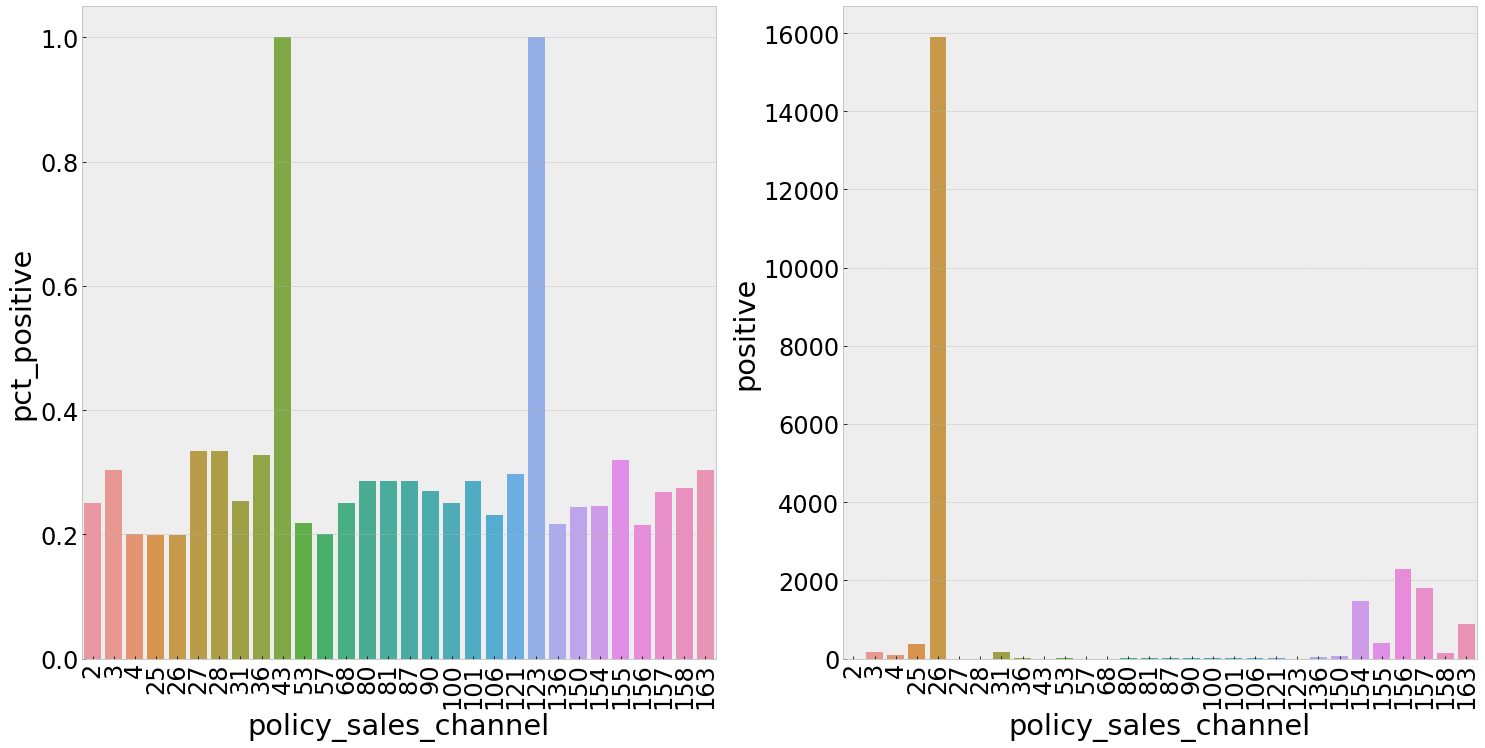

In [32]:


sales_channel.sort_values('pct_positive', ascending = False, inplace = True)
sales_channel.head(22)
plt.subplot(1,2,1)
sns.barplot(data = sales_channel.head(30), x = 'policy_sales_channel', y = 'pct_positive')
plt.xticks(rotation = 90);
plt.subplot(1,2,2)
sns.barplot(data = sales_channel.head(30), x = 'policy_sales_channel', y = 'positive')
plt.xticks(rotation = 90);

In [33]:
# sales_channel.head(30)

In [34]:
df.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'binned_age'],
      dtype='object')

### Previously insured

<AxesSubplot:xlabel='previously_insured', ylabel='count'>

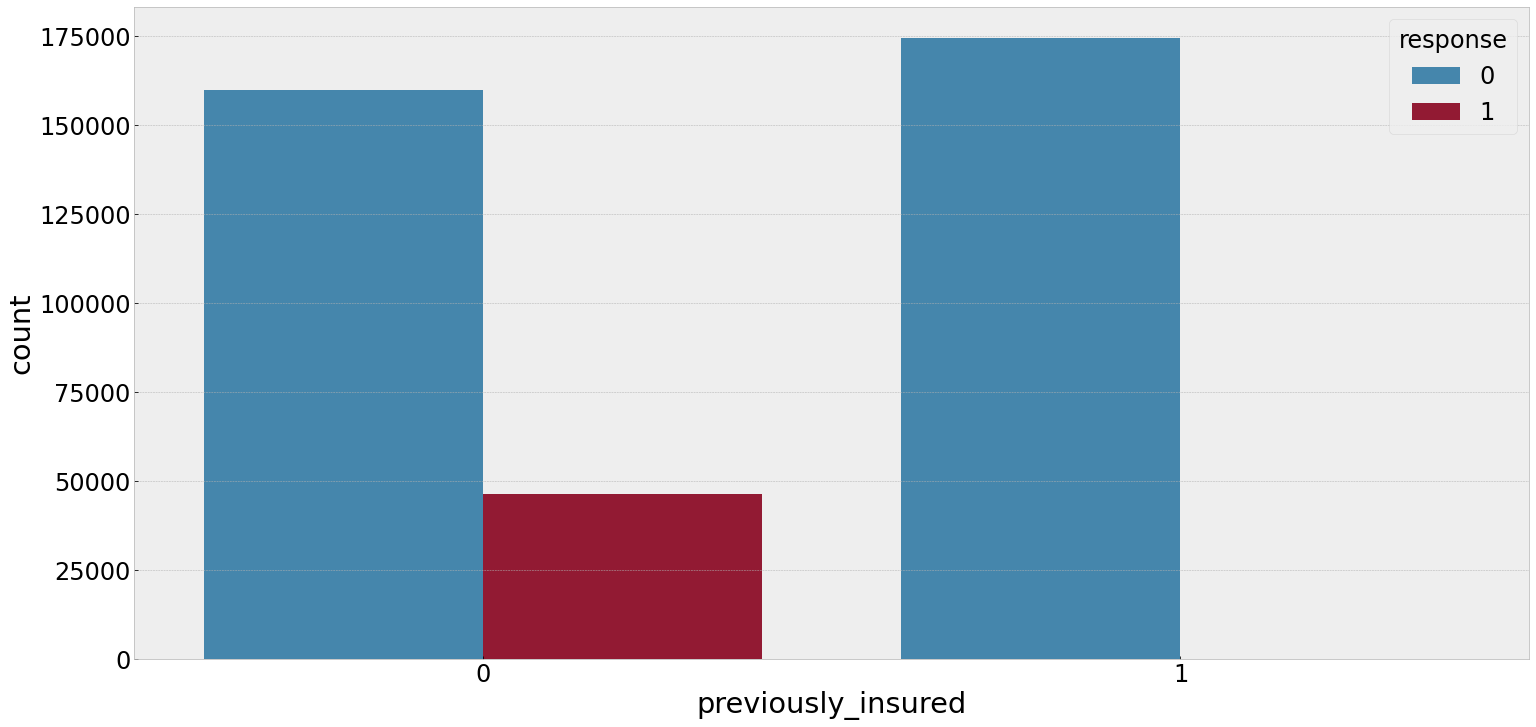

In [35]:
sns.countplot(x = 'previously_insured', hue = 'response', data = df)

### Annual Premium

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

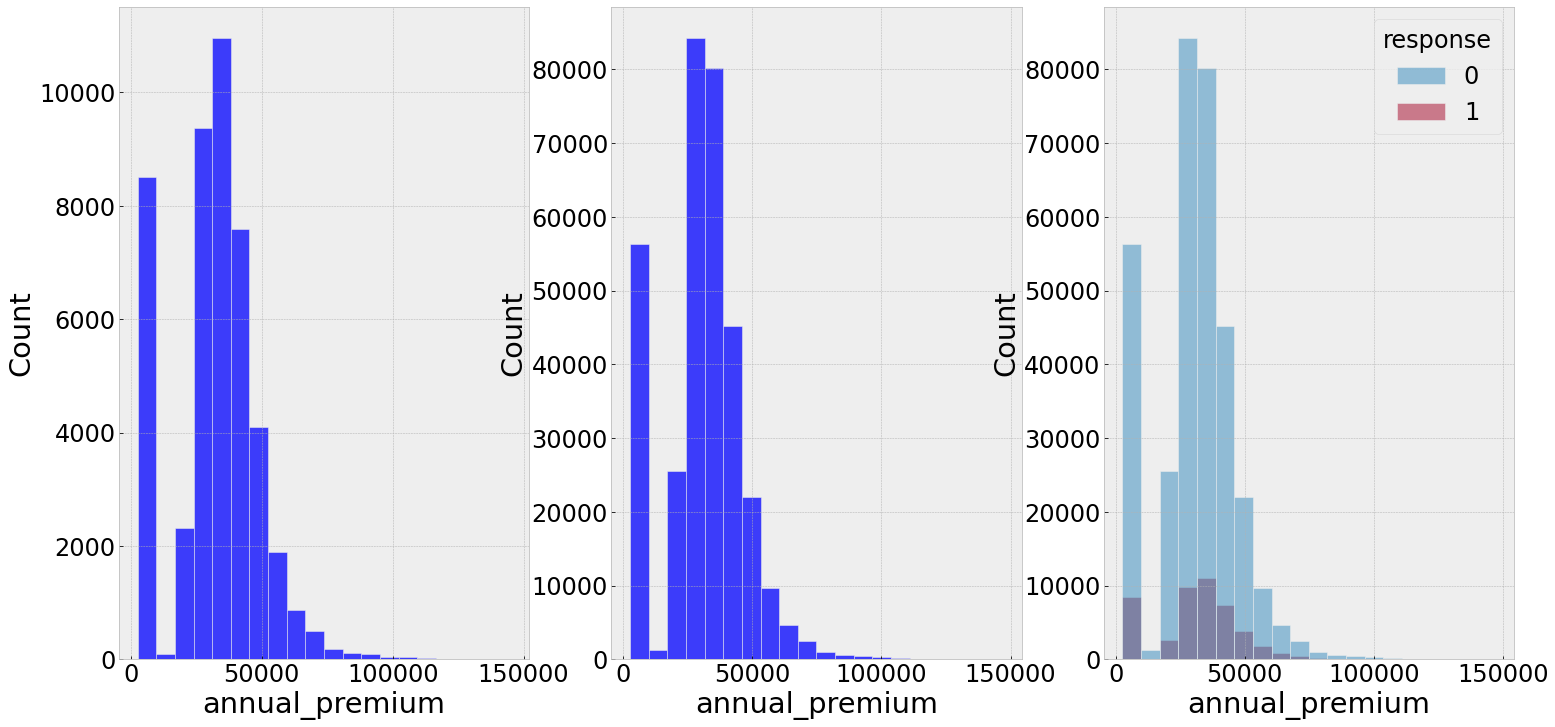

In [36]:
df_positive_feedback = df[df['response'] == 1];
df_positive_feedback = df_positive_feedback[df_positive_feedback['annual_premium'] < 150000];
df_negative_feedback = df[df['response'] == 0];
df_negative_feedback = df_negative_feedback[df_negative_feedback['annual_premium'] < 150000];
fig, axes = plt.subplots(1,3)
sns.histplot(x = 'annual_premium', data = df_positive_feedback, ax = axes[0], bins = 20)
sns.histplot(x = 'annual_premium', data = df_negative_feedback, ax = axes[1], bins = 20)
sns.histplot(x = 'annual_premium', data = df[df['annual_premium'] < 150000], hue = 'response', ax = axes[2], bins = 20)

In [37]:
df.columns


Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'binned_age'],
      dtype='object')

### vintage

154.11224577178334
154.38024336197176


<AxesSubplot:xlabel='vintage'>

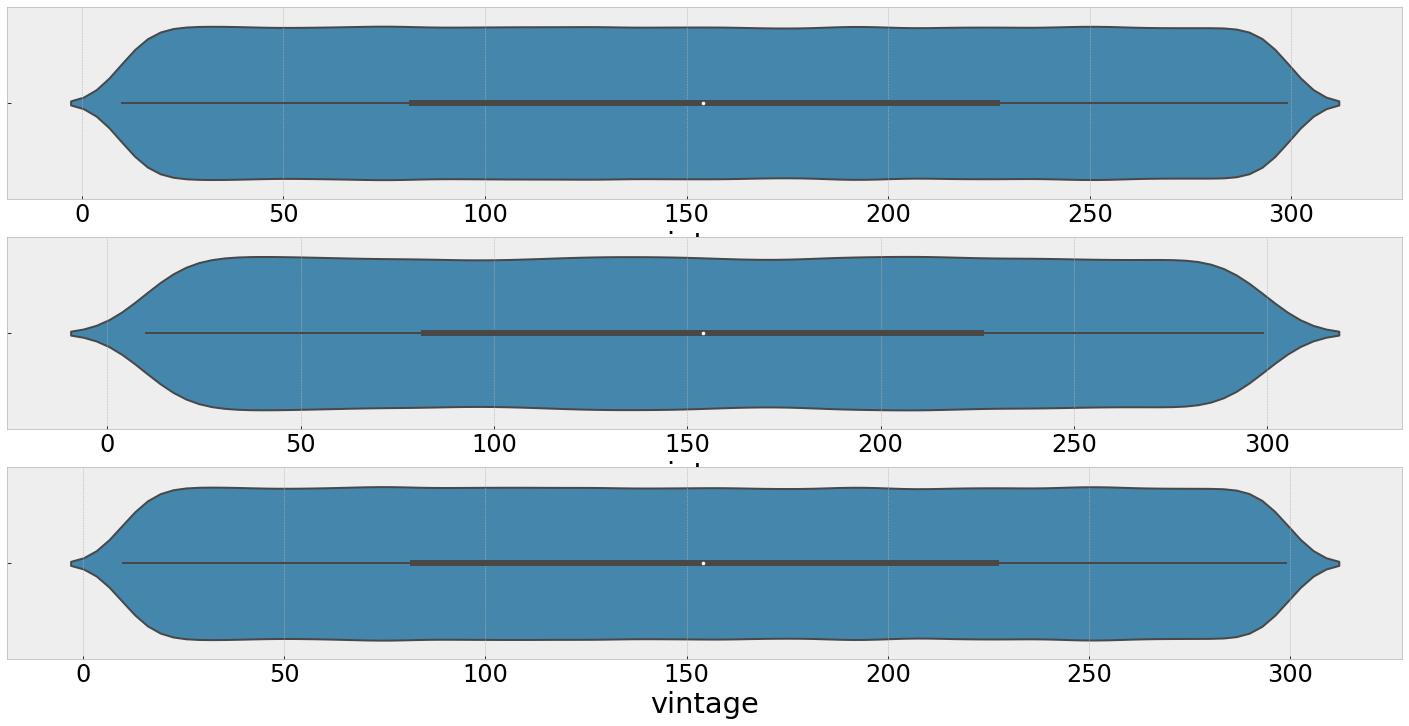

In [38]:
# sns.regplot(x = 'vintage', y = 'response', data = df)
df_positive_feedback = df[df['response'] == 1];
df_negative_feedback = df[df['response'] == 0];
print(df_positive_feedback.vintage.mean())
print(df_negative_feedback.vintage.mean())
plt.subplot(3,1,1)
sns.violinplot(x = 'vintage', data = df)
plt.subplot(3,1,2)
sns.violinplot(x = 'vintage', data = df_positive_feedback)
plt.subplot(3,1,3)
sns.violinplot(x = 'vintage', data = df_negative_feedback)

In [39]:
df_positive_feedback.shape


(46710, 13)

In [40]:
df_negative_feedback.shape

(334399, 13)

## Transforming Data

### Splitting Dataset

In [41]:
X = df.drop('response', axis = 1)
y = df['response'].copy()
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size = 0.2)

x_validation = x_val.copy()  # to be used in the api test
y_validation = y_val.copy()

df_clean = pd.concat([x_train, y_train], axis = 1)


## Rescaling

In [42]:
# df_clean.age.hist(bins = 60)  # Rescale
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

df_clean['age'] = mms_age.fit_transform( df_clean[['age']].values)
df_clean['vintage'] = mms_vintage.fit_transform( df_clean[['vintage']].values)

pickle.dump( mms_age, open('./age_scaler.pkl', 'wb'))
pickle.dump( mms_vintage, open('./vintage_scaler.pkl', 'wb'))

## Standardization

In [43]:
ss = pp.StandardScaler()
df_clean['annual_premium'] = ss.fit_transform(df_clean[['annual_premium']].values)
pickle.dump( ss, open('./annual_premium_scaler.pkl', 'wb'))

## Normalization

In [44]:
# df_clean.response.hist()

## Encoding categorical variables

In [45]:
df_clean.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'binned_age',
       'response'],
      dtype='object')

In [46]:
# df_clean.region_code.nunique()  # 53 - 
# df_clean.policy_sales_channel.nunique()  # 151 - 
# df_clean.vehicle_age.nunique()  # 3, continuous - 1,2,3... 

# Doing Gender one hot
t_enc_gender = df_clean.groupby('gender')['response'].mean()
df_clean.loc[:,'gender'] = df_clean['gender'].map( t_enc_gender)
pickle.dump(t_enc_gender, open('./target_encode_gender.pkl', 'wb'))

# Target Encoding Region
t_enc_region = df_clean.groupby('region_code')['response'].mean()
df_clean.loc[:, 'region_code'] = df_clean['region_code'].map(t_enc_region)
pickle.dump(t_enc_region, open('./target_encode_region.pkl', 'wb'))


# One Hot Encoding Vehicle
df_clean = pd.get_dummies(df_clean, prefix='vehicle_age', columns = ['vehicle_age'])
# use pandas to do transform, not saving it


# Frequency Encoding Policy Channel
# group by var and count # of examples.
fr_policy_sales_channel = df.groupby('policy_sales_channel').size() / len(df_clean)  # getting from df , not df_clean - does not cover all options for mapping
df_clean.loc[:,'policy_sales_channel'] = df_clean['policy_sales_channel'].map(fr_policy_sales_channel)
pickle.dump(fr_policy_sales_channel, open('./fe_policy_sales_channel.pkl', 'wb'))

# Vehicle Damage map label
map_key = {'Yes':1,'No':0}
df_clean.loc[:,'vehicle_damage'] = df_clean['vehicle_damage'].map(map_key)
# use pandas to do transform, not saving it

In [47]:
fr_policy_sales_channel

policy_sales_channel
1      0.003523
2      0.000013
3      0.001715
4      0.001669
6      0.000010
7      0.005241
8      0.004969
9      0.000554
10     0.000866
11     0.003946
12     0.002568
13     0.006117
14     0.002040
15     0.002913
16     0.001715
17     0.000052
18     0.000548
19     0.000728
20     0.000089
21     0.000485
22     0.001089
23     0.001384
24     0.002460
25     0.006061
26     0.261408
27     0.000010
28     0.000010
29     0.002765
30     0.004625
31     0.002070
32     0.000069
33     0.000010
34     0.000010
35     0.000246
36     0.000171
37     0.000499
38     0.000033
39     0.000033
40     0.000049
41     0.000003
42     0.000433
43     0.000003
44     0.000331
45     0.000154
46     0.000052
47     0.000207
48     0.000066
49     0.000046
50     0.000007
51     0.000039
52     0.003460
53     0.000105
54     0.000328
55     0.004146
56     0.000213
57     0.000016
58     0.000030
59     0.000417
60     0.001696
61     0.001899
62     0.000020
63 

In [48]:
df_clean.head(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,binned_age,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
210091,153227,0.137755,0.200000,0.123535,0.242696,1,0,1,-0.078749,0.968858,"(30, 35]",0,1,0,0
251586,104844,0.137755,0.753846,0.115460,0.261408,1,1,0,-1.623930,0.539792,"(65, 70]",0,1,0,0
3200,25616,0.103057,0.046154,0.080209,0.012742,1,1,0,0.800682,0.906574,"(20, 25]",0,0,1,0
376557,344998,0.103057,0.292308,0.186446,0.261408,1,1,0,0.663614,0.536332,"(35, 40]",0,1,0,0
89124,330365,0.103057,0.476923,0.089810,0.242696,1,1,0,0.429180,0.903114,"(50, 55]",0,1,0,0


In [49]:
fr_policy_sales_channel.head()

policy_sales_channel
1    0.003523
2    0.000013
3    0.001715
4    0.001669
6    0.000010
dtype: float64

## Validation Data preparation

In [50]:
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 144490 to 173784
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    76222 non-null  int64   
 1   gender                76222 non-null  object  
 2   age                   76222 non-null  int64   
 3   region_code           76222 non-null  int32   
 4   policy_sales_channel  76222 non-null  int32   
 5   driving_license       76222 non-null  int64   
 6   vehicle_age           76222 non-null  object  
 7   vehicle_damage        76222 non-null  object  
 8   previously_insured    76222 non-null  int64   
 9   annual_premium        76222 non-null  float64 
 10  vintage               76222 non-null  int64   
 11  binned_age            74908 non-null  category
dtypes: category(1), float64(1), int32(2), int64(5), object(3)
memory usage: 6.5+ MB


In [51]:
# gender
x_val.loc[:,'gender'] = x_val.loc[:,'gender'].map( t_enc_gender)

# Target Encoding Region
x_val.loc[:, 'region_code'] = x_val['region_code'].map(t_enc_region)

# # One Hot Encoding Vehicle
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns = ['vehicle_age'])

# Frequency Encoding Policy Channel
# group by var and count # of examples.
x_val.loc[:,'policy_sales_channel'] = x_val['policy_sales_channel'].map(fr_policy_sales_channel)

# Vehicle Damage map label
map_key = {'Yes':1,'No':0}
x_val.loc[:,'vehicle_damage'] = x_val['vehicle_damage'].map(map_key)


x_val['annual_premium'] = ss.transform(x_val[['annual_premium']].values)
# x_val = x_val.fillna( 0 )  # some regions not in the test dataset ... 

x_val['age'] = mms_age.transform( x_val[['age']].values)
x_val['vintage'] = mms_vintage.transform( x_val[['vintage']].values)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [52]:
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 144490 to 173784
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     76222 non-null  int64   
 1   gender                 76222 non-null  float64 
 2   age                    76222 non-null  float64 
 3   region_code            76222 non-null  float64 
 4   policy_sales_channel   76222 non-null  float64 
 5   driving_license        76222 non-null  int64   
 6   vehicle_damage         76222 non-null  int64   
 7   previously_insured     76222 non-null  int64   
 8   annual_premium         76222 non-null  float64 
 9   vintage                76222 non-null  float64 
 10  binned_age             74908 non-null  category
 11  vehicle_age_1-2 Year   76222 non-null  uint8   
 12  vehicle_age_< 1 Year   76222 non-null  uint8   
 13  vehicle_age_> 2 Years  76222 non-null  uint8   
dtypes: category(1), float64(6), int6

In [53]:
x_val[x_val['policy_sales_channel'].isna()]
# x_val.dropna(inplace = True)
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 144490 to 173784
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     76222 non-null  int64   
 1   gender                 76222 non-null  float64 
 2   age                    76222 non-null  float64 
 3   region_code            76222 non-null  float64 
 4   policy_sales_channel   76222 non-null  float64 
 5   driving_license        76222 non-null  int64   
 6   vehicle_damage         76222 non-null  int64   
 7   previously_insured     76222 non-null  int64   
 8   annual_premium         76222 non-null  float64 
 9   vintage                76222 non-null  float64 
 10  binned_age             74908 non-null  category
 11  vehicle_age_1-2 Year   76222 non-null  uint8   
 12  vehicle_age_< 1 Year   76222 non-null  uint8   
 13  vehicle_age_> 2 Years  76222 non-null  uint8   
dtypes: category(1), float64(6), int6

In [54]:
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 144490 to 173784
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     76222 non-null  int64   
 1   gender                 76222 non-null  float64 
 2   age                    76222 non-null  float64 
 3   region_code            76222 non-null  float64 
 4   policy_sales_channel   76222 non-null  float64 
 5   driving_license        76222 non-null  int64   
 6   vehicle_damage         76222 non-null  int64   
 7   previously_insured     76222 non-null  int64   
 8   annual_premium         76222 non-null  float64 
 9   vintage                76222 non-null  float64 
 10  binned_age             74908 non-null  category
 11  vehicle_age_1-2 Year   76222 non-null  uint8   
 12  vehicle_age_< 1 Year   76222 non-null  uint8   
 13  vehicle_age_> 2 Years  76222 non-null  uint8   
dtypes: category(1), float64(6), int6

# Feature Selection

In [55]:
df_clean.dtypes

id                          int64
gender                    float64
age                       float64
region_code               float64
policy_sales_channel      float64
driving_license             int64
vehicle_damage              int64
previously_insured          int64
annual_premium            float64
vintage                   float64
binned_age               category
response                    int64
vehicle_age_1-2 Year        uint8
vehicle_age_< 1 Year        uint8
vehicle_age_> 2 Years       uint8
dtype: object

In [56]:
df_clean.binned_age.unique()

[(30, 35], (65, 70], (20, 25], (35, 40], (50, 55], ..., (45, 50], (55, 60], (75, 80], (70, 75], (80, 85]]
Length: 14
Categories (13, interval[int64]): [(20, 25] < (25, 30] < (30, 35] < (35, 40] ... (65, 70] < (70, 75] < (75, 80] < (80, 85]]

## Relevance

In [57]:
df_clean.vehicle_damage.unique()

array([0, 1], dtype=int64)

In [58]:
# model
forest = en.ExtraTreesClassifier( n_estimators = 250, random_state = 0, n_jobs = -1)

# data prep
x_train_n = df_clean.drop(['id','response','binned_age'], axis = 1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)




ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                 feature  importance
0                vintage    0.273227
0         annual_premium    0.245013
0                    age    0.164723
0            region_code    0.105039
0         vehicle_damage    0.067866
0   policy_sales_channel    0.060589
0     previously_insured    0.056067
0   vehicle_age_< 1 Year    0.012518
0   vehicle_age_1-2 Year    0.006962
0                 gender    0.004863
0  vehicle_age_> 2 Years    0.002654
0        driving_license    0.000479


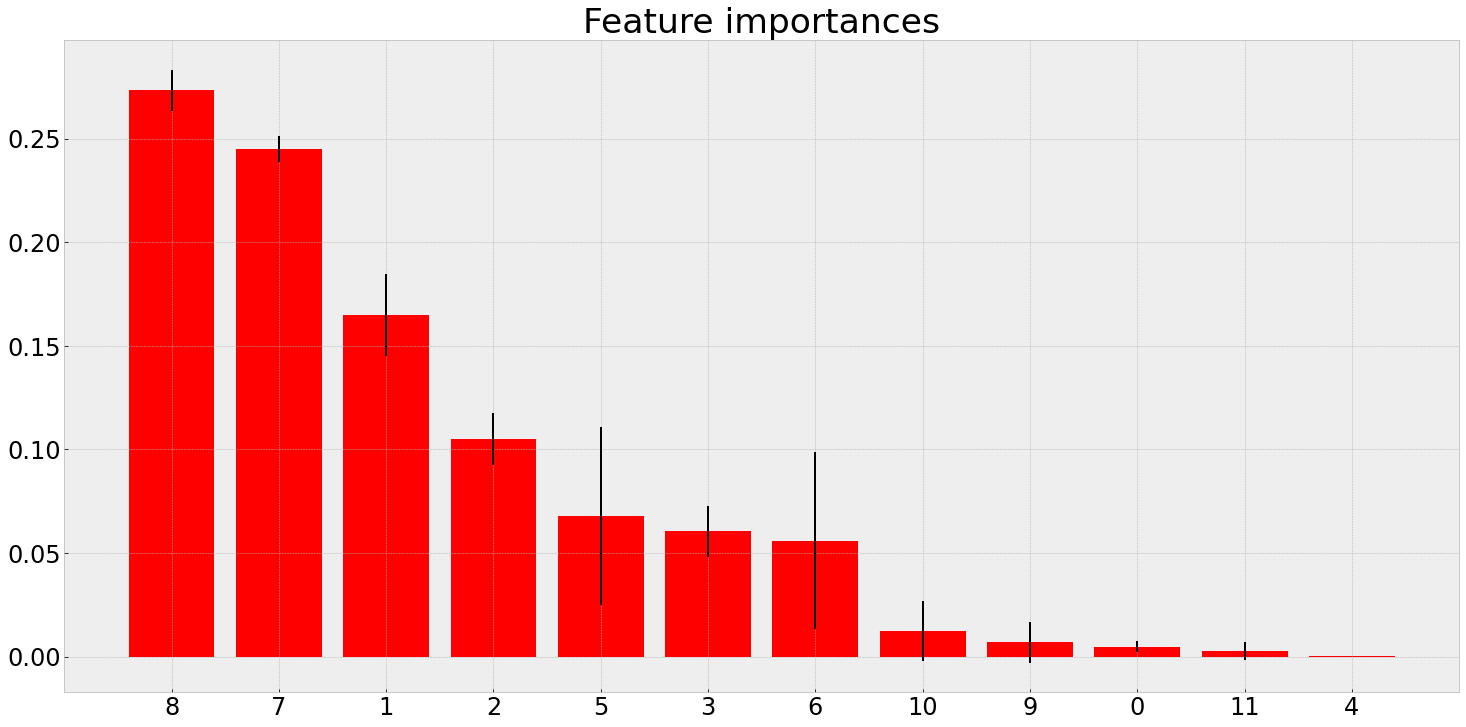

In [59]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df_imp = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance':j}, index = [0])
    df_imp = pd.concat([df_imp,aux], axis = 0)

df_imp = df_imp.sort_values('importance', ascending = False)
print(df_imp.sort_values('importance', ascending = False))

# graph plot
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# Machine Learning

In [60]:
df_imp.feature.values

array(['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'policy_sales_channel', 'previously_insured',
       'vehicle_age_< 1 Year', 'vehicle_age_1-2 Year', 'gender',
       'vehicle_age_> 2 Years', 'driving_license'], dtype=object)

In [61]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'previously_insured','policy_sales_channel']

x_train = df_clean[cols_selected]
x_val_full = x_val.copy()  # so we can work with all columns in performance section
x_val = x_val[cols_selected]

In [62]:
x_train.head()

,vintage,annual_premium,age,region_code,vehicle_damage,previously_insured,policy_sales_channel
210091,0.968858,-0.078749,0.200000,0.123535,0,1,0.242696
251586,0.539792,-1.623930,0.753846,0.115460,1,0,0.261408
3200,0.906574,0.800682,0.046154,0.080209,1,0,0.012742
376557,0.536332,0.663614,0.292308,0.186446,1,0,0.261408
89124,0.903114,0.429180,0.476923,0.089810,1,0,0.242696


In [63]:
x_val.head()

,vintage,annual_premium,age,region_code,vehicle_damage,previously_insured,policy_sales_channel
144490,0.650519,0.546891,0.092308,0.072075,0,1,0.442079
200551,0.854671,-0.560928,0.030769,0.100411,0,1,0.442079
329050,0.062284,0.577525,0.153846,0.119754,1,0,0.442079
86057,0.733564,0.099648,0.292308,0.100411,1,0,0.261408
172039,0.951557,-0.118568,0.415385,0.186446,1,0,0.261408


## K Neighbors

In [64]:
x_val.info()
# x_val.policy_sales_channel.fillna(0, inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 144490 to 173784
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vintage               76222 non-null  float64
 1   annual_premium        76222 non-null  float64
 2   age                   76222 non-null  float64
 3   region_code           76222 non-null  float64
 4   vehicle_damage        76222 non-null  int64  
 5   previously_insured    76222 non-null  int64  
 6   policy_sales_channel  76222 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 4.7 MB


In [65]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors =  2)

# training
knn_model.fit(x_train, y_train)

# model prediction - generalization
yhat_knn = knn_model.predict_proba( x_val )


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

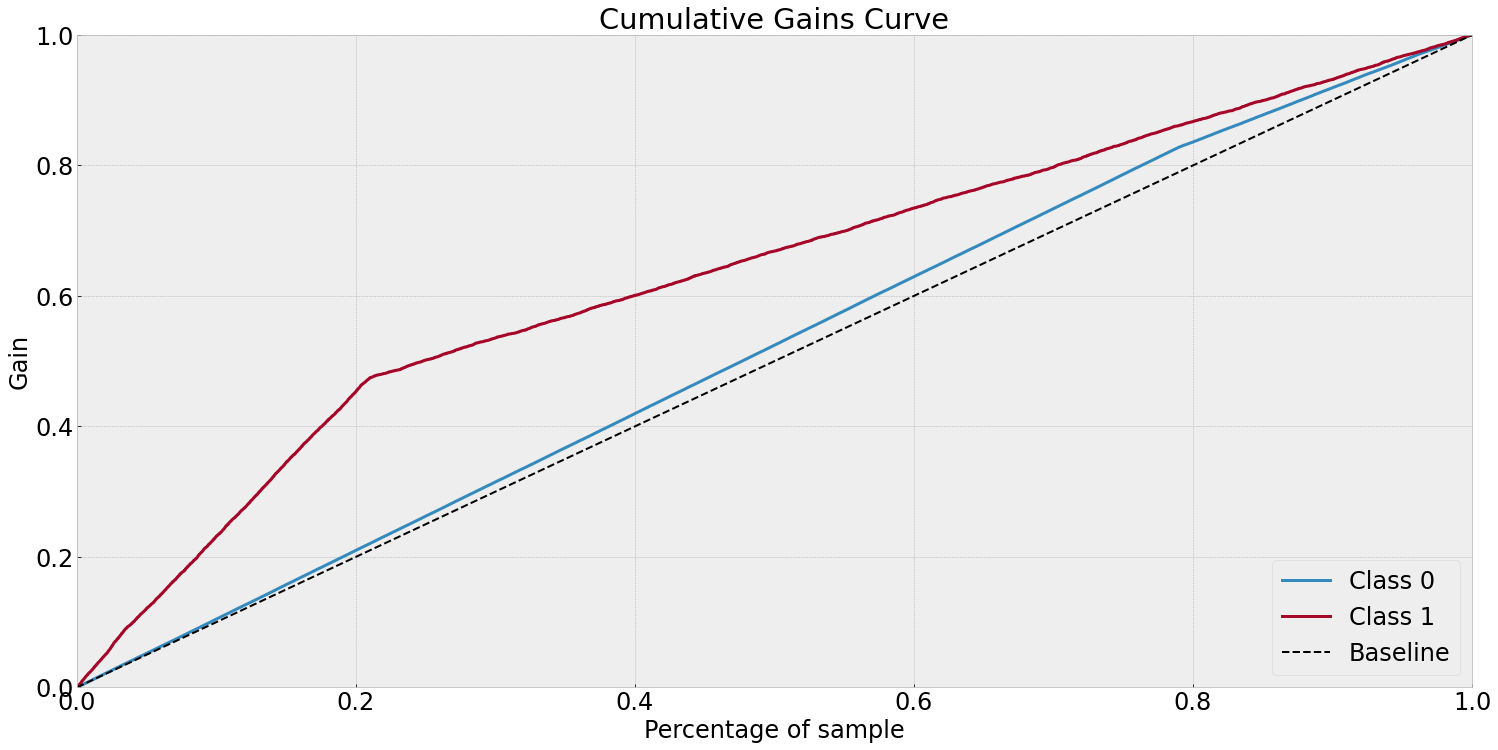

In [66]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )

## Logistic Regression

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

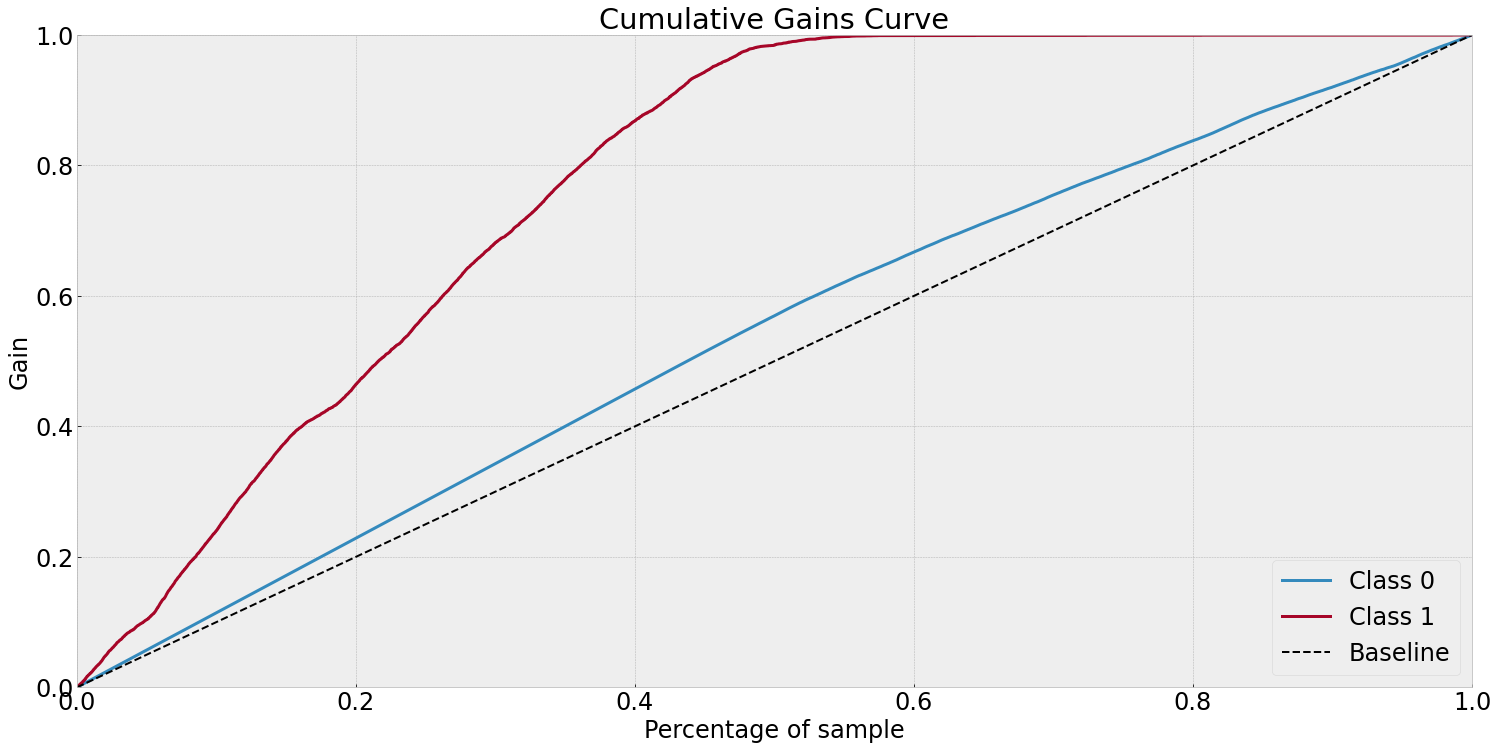

In [67]:
# model obj
lr_model = lm.LogisticRegression( random_state = 42)

# training
lr_model.fit( x_train, y_train)

# predict
yhat_lr = lr_model.predict_proba( x_val)

# gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr)



# Model Performance

In [68]:
model_perf = x_val_full.copy()
model_perf['response'] = y_val.copy()

# score propensity
model_perf['score'] = yhat_knn[:,1].tolist()

# sort customers according to prop. score
model_perf = model_perf.sort_values('score', ascending = False)

# set id column from index
model_perf['id'] = model_perf.index  # set id column from index.

def precision_at_k( data, k = 2000):
    
    # reset index and keep ids
    data = data.reset_index(drop = True)

    # do ranking order
    data['ranking'] = data.index + 1

    # precision at k:
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k = 2000):
    data = data.reset_index(drop = True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']


# comp precision k  // Doing Precision Top K
# The Number of correct predictions till k  /   The Number of predictions done.
# model_perf[['id', 'response', 'score', 'ranking', 'precision_at_k']].head()

# computing precision 
precision_at_50 = precision_at_k(model_perf, k=50)
print('Precision at K: {}'.format(precision_at_50))

recall_at_50 = recall_at_k(model_perf, k=50)
print('Precision at K: {}'.format(recall_at_50))




Precision at K: 0.27450980392156865
Precision at K: 0.0014636696288552013


In [84]:
model_perf.sample(10)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,binned_age,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,response,score
226503,226503,0.137755,0.538462,0.123535,0.261408,1,1,0,-0.042942,0.906574,"(50, 55]",1,0,0,1,0.5
87030,87030,0.137755,0.015385,0.085792,0.442079,1,0,1,0.210383,0.851211,"(20, 25]",0,1,0,0,0.0
357574,357574,0.137755,0.600000,0.105885,0.021923,1,1,0,-1.623930,0.702422,"(55, 60]",1,0,0,0,0.0
281506,281506,0.137755,0.215385,0.186446,0.242696,1,0,1,0.108542,0.117647,"(30, 35]",1,0,0,0,0.0
315898,315898,0.103057,0.338462,0.186446,0.261408,1,1,0,0.667741,0.792388,"(40, 45]",1,0,0,0,1.0
162822,162822,0.103057,0.046154,0.080209,0.442079,1,0,1,-0.709040,0.391003,"(20, 25]",0,1,0,0,0.0
168801,168801,0.137755,0.400000,0.186446,0.242696,1,0,1,1.036510,0.425606,"(45, 50]",1,0,0,0,0.0
161796,161796,0.137755,0.569231,0.096423,0.006061,1,1,1,1.171137,0.975779,"(55, 60]",1,0,0,0,0.0
210943,210943,0.103057,0.276923,0.119754,0.242696,1,1,0,-0.612314,0.166090,"(35, 40]",1,0,0,1,0.5
181782,181782,0.103057,0.307692,0.186446,0.261408,1,1,1,0.267117,0.173010,"(35, 40]",1,0,0,0,0.0


# Deploy

In [70]:
# Saving trained model:
# Logistic Regression:
pickle.dump( lr_model, open('./model_log_regression.pkl', 'wb'))

## Health Insurance Class

### Health Insurance Class

class HealthInsurance:
    def __init__(self):
        self.home_path = './'
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'annual_premium_scaler.pkl'))
        self.age_scaler = pickle.load(open(self.home_path + 'age_scaler.pkl'))
        self.vintage_scaler = pickle.load(open(self.home_path + 'vintage_scaler.pkl'))
        self.target_encode_gender_scaler =  pickle.load(open(self.home_path + 'target_encode_gender.pkl'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'target_encode_region.pkl'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + 'fe_policy_sales_channel.pkl'))
        
    def data_cleaning( self, df1):
        # Column rename
        # columns_names = [ ... ]
        # 
        # 5.48m
        # df1.columns = cols_names
        
        return df1
    
    def feature_engineering(self, df2):
        # Vehicle Damage map label
        map_key = {'Yes':1,'No':0}
        df_clean.loc[:,'vehicle_damage'] = df_clean['vehicle_damage'].map(map_key)
        
        # One Hot Encoding Vehicle
        df_clean = pd.get_dummies(df_clean, prefix='vehicle_age', columns = ['vehicle_age'])
        
        return df2
    
    def data_preparation(self, df_clean):
        # Standardization
        
        df_clean['annual_premium'] = self.annual_premium_scaler.transform(df_clean[['annual_premium']].values)

        # rescaling
        df_clean['age'] = self.age_scaler.transform( df_clean[['age']].values)
        df_clean['vintage'] = self.vintage_scaler.transform( df_clean[['vintage']].values)
        
        # Doing Gender one hot
        df_clean.loc[:,'gender'] = df_clean['gender'].map( self.target_encode_gender_scaler)

        # Target Encoding Region
        df_clean.loc[:, 'region_code'] = df_clean['region_code'].map(self.target_encode_region_code_scaler)
        pickle.dump(t_enc_region, open('./target_encode_region.pkl', 'wb'))


        # One Hot Encoding Vehicle
        df_clean = pd.get_dummies(df_clean, prefix='vehicle_age', columns = ['vehicle_age'])
        # use pandas to do transform, not saving it


        # Frequency Encoding Policy Channel
        # group by var and count # of examples.
        
        df_clean.loc[:,'policy_sales_channel'] = df_clean['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        

        # Vehicle Damage map label
#         map_key = {'Yes':1,'No':0}
#         df_clean.loc[:,'vehicle_damage'] = df_clean['vehicle_damage'].map(map_key)
        # use pandas to do transform, not saving it
        
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                         'vehicle_damage', 'previously_insured','policy_sales_channel']
        
        return df_clean[ cols_selected ]

    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient = 'records', date_format = 'iso')
        
        
        

## API Handler

import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loads model
path = './'
model = pickle.load(open(path + 'model_health_insurance.pkl', 'rb'))  # memory bank alt.

# API init
app = Flask( __name__ )

@app.route ('/predict', methods = ['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance( test_json, dict):  # unique item
            test_raw = pd.DataFrame( test_json, index = [0])
        else:  # multiple items
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
        
        # start Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df = pipeline.data_cleaning( test_raw )
        
        # features
        df = pipeline.feature_engineering( df )
        
        # data prep
        df = pipeline.data_preparation ( df )
        
        # prediction
        df = pipeline.get_prediction(model, test_raw, df)
        
        return df
    else:
        return Response('{}', status = 200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug = True)
    
    
    
        
        

## API test

In [71]:
import requests
import json
# load dataset
df_test = x_validation #.drop('response', axis = 1)
df_test['response'] = y_validation


cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'previously_insured','policy_sales_channel']

cols_selected.append('vehicle_age')
cols_selected.append('gender')
df_test = df_test[cols_selected]

# df_test = df_test.sample(10)

#converting df to json

data = json.dumps( df_test.to_dict(orient = 'records'))
df_test.head()

,vintage,annual_premium,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,vehicle_age,gender
144490,198,39975.0,26,15,No,1,152,< 1 Year,Male
200551,257,20917.0,22,46,No,1,152,< 1 Year,Male
329050,28,40502.0,30,41,Yes,0,152,< 1 Year,Male
86057,222,32281.0,39,46,Yes,0,26,1-2 Year,Male
172039,285,28527.0,47,28,Yes,0,26,1-2 Year,Female


In [72]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 144490 to 173784
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vintage               76222 non-null  int64  
 1   annual_premium        76222 non-null  float64
 2   age                   76222 non-null  int64  
 3   region_code           76222 non-null  int32  
 4   vehicle_damage        76222 non-null  object 
 5   previously_insured    76222 non-null  int64  
 6   policy_sales_channel  76222 non-null  int32  
 7   vehicle_age           76222 non-null  object 
 8   gender                76222 non-null  object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 5.2+ MB


In [73]:
print(df_test.head())
#df_test = df_test[cols_selected]
#data = json.dumps( df_test.to_dict(orient = 'records'))
# df_test = pd.get_dummies(df_test, prefix='vehicle_age', columns=['vehicle_age'])
df_test.head()

        vintage  annual_premium  age  region_code vehicle_damage  previously_insured  policy_sales_channel vehicle_age  gender
144490      198         39975.0   26           15             No                   1                   152    < 1 Year    Male
200551      257         20917.0   22           46             No                   1                   152    < 1 Year    Male
329050       28         40502.0   30           41            Yes                   0                   152    < 1 Year    Male
86057       222         32281.0   39           46            Yes                   0                    26    1-2 Year    Male
172039      285         28527.0   47           28            Yes                   0                    26    1-2 Year  Female


,vintage,annual_premium,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,vehicle_age,gender
144490,198,39975.0,26,15,No,1,152,< 1 Year,Male
200551,257,20917.0,22,46,No,1,152,< 1 Year,Male
329050,28,40502.0,30,41,Yes,0,152,< 1 Year,Male
86057,222,32281.0,39,46,Yes,0,26,1-2 Year,Male
172039,285,28527.0,47,28,Yes,0,26,1-2 Year,Female


In [74]:
 #API call
# url = 'http://0.0.0.0:5000/predict'
#url = 'https:// ... heroku...'
url = 'http://localhost:5000/predict'
header = {'Content-type': 'application/json'}

print(f'Sending {df_test.head()}')
r = requests.post( url, data=data, headers=header)
print('Status code {}'.format(r.status_code))


Sending         vintage  annual_premium  age  region_code vehicle_damage  previously_insured  policy_sales_channel vehicle_age  gender
144490      198         39975.0   26           15             No                   1                   152    < 1 Year    Male
200551      257         20917.0   22           46             No                   1                   152    < 1 Year    Male
329050       28         40502.0   30           41            Yes                   0                   152    < 1 Year    Male
86057       222         32281.0   39           46            Yes                   0                    26    1-2 Year    Male
172039      285         28527.0   47           28            Yes                   0                    26    1-2 Year  Female
Status code 200


In [75]:
# data

In [76]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys() )
d1.sort_values('prediction', ascending = False).head()

,vintage,annual_premium,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,vehicle_age,gender,prediction
18289,0.359862,25.662437,0.030769,0.186446,1,0,163,1-2 Year,0.137755,0.405478
62959,0.993080,26.686725,0.307692,0.186446,1,0,122,1-2 Year,0.137755,0.391647
5561,0.432526,24.273972,0.784615,0.186446,1,0,122,> 2 Years,0.137755,0.369187
32358,0.321799,15.148503,0.553846,0.186446,1,0,56,1-2 Year,0.137755,0.358265
4104,0.826990,9.941207,0.015385,0.186446,1,0,156,< 1 Year,0.103057,0.357385


In [85]:
d1.sample(14)

,vintage,annual_premium,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,vehicle_age,gender,prediction
9339,0.747405,0.714360,0.461538,0.186446,1,0,124,1-2 Year,0.137755,0.290642
13677,0.792388,0.044135,0.323077,0.111760,1,0,124,1-2 Year,0.103057,0.228229
14930,0.920415,1.016863,0.446154,0.186446,0,1,26,1-2 Year,0.103057,0.000911
11769,0.487889,2.334062,0.446154,0.186446,0,1,124,1-2 Year,0.137755,0.000942
37839,0.027682,0.358728,0.030769,0.096423,1,0,160,< 1 Year,0.137755,0.246192
59510,0.449827,0.630074,0.630769,0.186446,1,0,125,1-2 Year,0.137755,0.316847
10584,0.083045,0.433249,0.261538,0.186446,1,0,26,1-2 Year,0.137755,0.296615
7000,0.377163,0.952165,0.292308,0.061471,1,0,8,1-2 Year,0.103057,0.217823
49889,0.235294,0.386688,0.338462,0.186446,1,0,124,1-2 Year,0.103057,0.295774
72410,0.494810,0.030591,0.353846,0.100411,0,1,122,1-2 Year,0.103057,0.000716
